In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('/Users/omniscience/Desktop/project/ML/ing/data/1984-2021_mc.csv')
print(df.shape)
df.head()

(13516, 10)


,YEAR,MO,DY,PS,PRECTOTCORR,T2M,QV2M,ALLSKY_SFC_SW_DWN,WS50M,ALLSKY_SFC_PAR_TOT
0,1984,1,1,74.75,0.17,8.19,4.88,5.26,1.19,98.7
1,1984,1,2,74.68,1.18,7.11,5.31,4.80,2.26,93.7
2,1984,1,3,74.68,1.97,7.11,6.41,3.61,2.53,72.3
3,1984,1,4,74.76,0.13,8.51,6.90,3.57,1.98,71.6
4,1984,1,5,74.75,0.02,10.40,6.84,4.91,1.44,95.5


# Precipitation of 1984 to 2021

In [3]:
df['date'] = df['YEAR'].map(str)+"/"+df['MO'].map(str)+"/"+df['DY'].map(str)
pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.head()

,YEAR,MO,DY,PS,PRECTOTCORR,T2M,QV2M,ALLSKY_SFC_SW_DWN,WS50M,ALLSKY_SFC_PAR_TOT,date
date,,,,,,,,,,,
1984-01-01,1984,1,1,74.75,0.17,8.19,4.88,5.26,1.19,98.7,1984/1/1
1984-01-02,1984,1,2,74.68,1.18,7.11,5.31,4.80,2.26,93.7,1984/1/2
1984-01-03,1984,1,3,74.68,1.97,7.11,6.41,3.61,2.53,72.3,1984/1/3
1984-01-04,1984,1,4,74.76,0.13,8.51,6.90,3.57,1.98,71.6,1984/1/4
1984-01-05,1984,1,5,74.75,0.02,10.40,6.84,4.91,1.44,95.5,1984/1/5


<AxesSubplot:title={'center':'Precipitation in Mexico City from 1984 to 2022'}, xlabel='date', ylabel='Precipitation(mm)'>

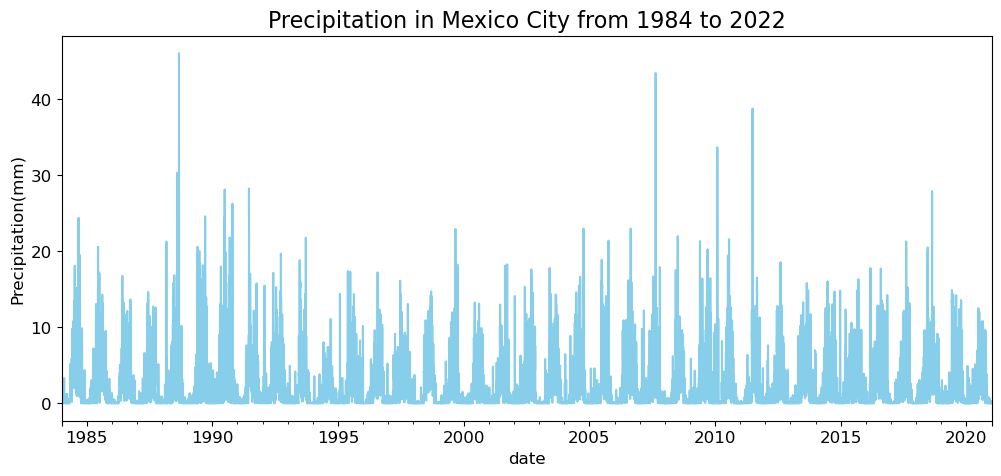

In [4]:
precip_df = df['PRECTOTCORR']
plt.figure(figsize=(12,5))
plt.title('Precipitation in Mexico City from 1984 to 2022',fontsize = 16)
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Precipitation(mm)',fontsize = 12)
plt.tick_params(axis = 'both',which = 'major',labelsize=12)
my_x_ticks = np.arange(2000,201,1000)
precip_df.plot(color = 'skyblue')

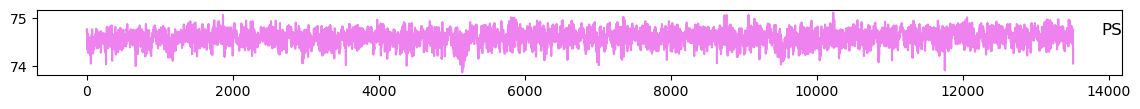

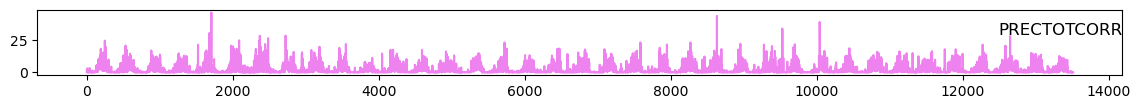

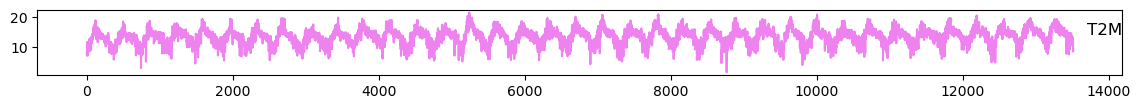

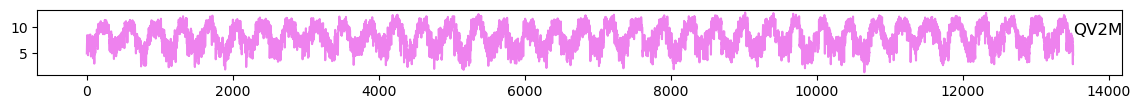

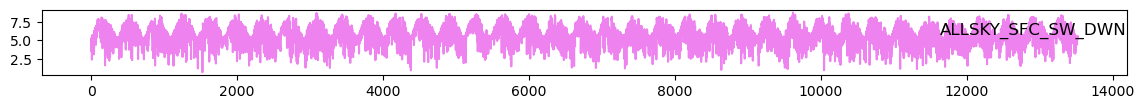

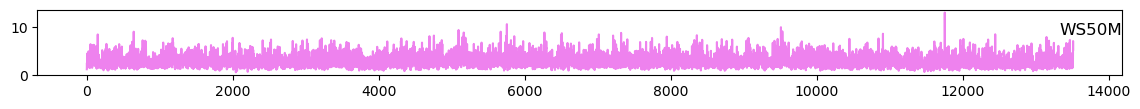

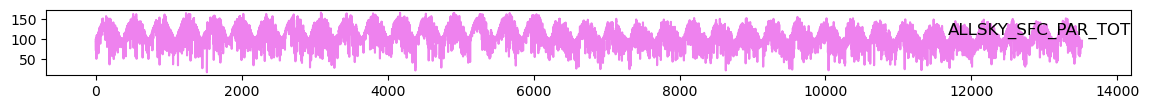

In [5]:
values = df.values
groups = [3,4,5,6,7,8,9]
i = 1
for group in groups:
    plt.figure(figsize=(14,7))
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group], color = 'violet')
    plt.title(df.columns[group], y = 0.5,loc = 'right')
    i += 1
plt.show()

## Data Normalization

In [6]:
prar_df = df.loc[:,['PRECTOTCORR','T2M','PS','QV2M','ALLSKY_SFC_SW_DWN','WS50M','ALLSKY_SFC_PAR_TOT']]
prar_df.head()

,PRECTOTCORR,T2M,PS,QV2M,ALLSKY_SFC_SW_DWN,WS50M,ALLSKY_SFC_PAR_TOT
date,,,,,,,
1984-01-01,0.17,8.19,74.75,4.88,5.26,1.19,98.7
1984-01-02,1.18,7.11,74.68,5.31,4.80,2.26,93.7
1984-01-03,1.97,7.11,74.68,6.41,3.61,2.53,72.3
1984-01-04,0.13,8.51,74.76,6.90,3.57,1.98,71.6
1984-01-05,0.02,10.40,74.75,6.84,4.91,1.44,95.5


In [7]:
def df_to_x_y(df,window_size=3): # using three days data to predict forth day
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [ a for a in df_as_np[i:i + window_size]]
        x.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(x),np.array(y)

In [8]:
x,y = df_to_x_y(prar_df)
x.shape,y.shape

((13513, 3, 7), (13513,))

In [9]:
x_train, y_train = x[:11000],y[:11000]
x_val, y_val = x[11000:12000],y[11000:12000]
x_test, y_test = x[12000:],y[12000:]
x_train.shape,y_train.shape,x_val.shape, y_val.shape,x_test.shape,y_test.shape

((11000, 3, 7), (11000,), (1000, 3, 7), (1000,), (1513, 3, 7), (1513,))

In [10]:
precip_train_mean = np.mean(x_train[:, :, 0])
precip_train_std = np.std(x_train[:, :, 0])

for i in range(1,7):
    x_train_mean = np.mean(x_train[:,:, i])
    x_train_std = np.std(x_train[:,:, i])

def preprocess(x):
    x[:, :, i] = (x[:, :, i] - x_train_mean)/x_train_std
    return x
def preprocess_output(y):
    y[:, ] = (y[:, ] - precip_train_mean)/precip_train_std
    return y

In [11]:
preprocess(x_train)
preprocess(x_val)
preprocess(x_test)

preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([-0.15516974, -0.42326946, -0.59120006, ..., -0.5529001 ,
       -0.62655387, -0.62655387])

# LSTM

In [12]:
model_LSTM = Sequential()
model_LSTM.add(InputLayer((3,7)))
model_LSTM.add(LSTM(64, return_sequences = True))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(8,'relu'))
model_LSTM.add(Dense(1,'linear'))

model_LSTM.summary()

2022-12-08 14:48:17.489682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 51,985
Trainable params: 51,985
Non-trainable params: 0
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('model_LSTM/',save_best_only = True)
model_LSTM.compile(loss = MeanSquaredError(), 
                   optimizer = Adam(learning_rate = 0.0001), 
                   metrics = [RootMeanSquaredError()]
              )

model_LSTM.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])

Epoch 1/10
334/344 [============================>.] - ETA: 0s - loss: 0.8821 - root_mean_squared_error: 0.9392

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 10s 21ms/step - loss: 0.8722 - root_mean_squared_error: 0.9339 - val_loss: 0.6702 - val_root_mean_squared_error: 0.8186
Epoch 2/10
333/344 [============================>.] - ETA: 0s - loss: 0.6868 - root_mean_squared_error: 0.8287

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 20ms/step - loss: 0.6866 - root_mean_squared_error: 0.8286 - val_loss: 0.6169 - val_root_mean_squared_error: 0.7854
Epoch 3/10
342/344 [============================>.] - ETA: 0s - loss: 0.6423 - root_mean_squared_error: 0.8014

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 20ms/step - loss: 0.6406 - root_mean_squared_error: 0.8004 - val_loss: 0.5891 - val_root_mean_squared_error: 0.7675
Epoch 4/10
338/344 [============================>.] - ETA: 0s - loss: 0.5972 - root_mean_squared_error: 0.7728

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 20ms/step - loss: 0.6113 - root_mean_squared_error: 0.7819 - val_loss: 0.5754 - val_root_mean_squared_error: 0.7585
Epoch 5/10
343/344 [============================>.] - ETA: 0s - loss: 0.5218 - root_mean_squared_error: 0.7223

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 20ms/step - loss: 0.5209 - root_mean_squared_error: 0.7217 - val_loss: 0.4900 - val_root_mean_squared_error: 0.7000
Epoch 6/10
338/344 [============================>.] - ETA: 0s - loss: 0.5000 - root_mean_squared_error: 0.7071

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 20ms/step - loss: 0.4992 - root_mean_squared_error: 0.7065 - val_loss: 0.4883 - val_root_mean_squared_error: 0.6988
Epoch 7/10
344/344 [==============================] - ETA: 0s - loss: 0.4974 - root_mean_squared_error: 0.7053

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 22ms/step - loss: 0.4974 - root_mean_squared_error: 0.7053 - val_loss: 0.4845 - val_root_mean_squared_error: 0.6960
Epoch 8/10
344/344 [==============================] - 2s 6ms/step - loss: 0.4943 - root_mean_squared_error: 0.7030 - val_loss: 0.4988 - val_root_mean_squared_error: 0.7063
Epoch 9/10
340/344 [============================>.] - ETA: 0s - loss: 0.4827 - root_mean_squared_error: 0.6948

INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


344/344 [==============================] - 7s 21ms/step - loss: 0.4924 - root_mean_squared_error: 0.7017 - val_loss: 0.4825 - val_root_mean_squared_error: 0.6946
Epoch 10/10
344/344 [==============================] - 2s 5ms/step - loss: 0.4918 - root_mean_squared_error: 0.7013 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6981


# Result

## Test Data

In [19]:
def postprocess_precip(arr):
    arr = (arr * precip_train_std) + precip_train_mean
    return arr

In [20]:
def plot_predictions_LSTM (model_LSTM, x, y, start = 600, end = 800):
    prediction = model_LSTM.predict(x)
    precip_prediction = postprocess_precip(prediction[:,0])
    precip_actual = postprocess_precip(y[:,])
    df = pd.DataFrame(data = {'Precipitation Prediction': precip_prediction,
                              'Precipitation Actual': precip_actual,
                              })
    plt.plot(df['Precipitation Prediction'][start:end], color = 'green')
    plt.plot(df['Precipitation Actual'][start:end], color = 'red')
    plt.legend(['Precipitation Prediction','Precipitation Actual'],loc=0)
    return df[start:end]

48/48 [==============================] - 0s 2ms/step


,Precipitation Prediction,Precipitation Actual
600,4.487978,2.61
601,3.717814,0.93
602,2.645931,0.73
603,2.833037,3.30
604,4.335431,8.88
...,...,...
795,0.456613,0.02
796,0.447570,0.00
797,0.381640,0.03
798,0.400276,0.07


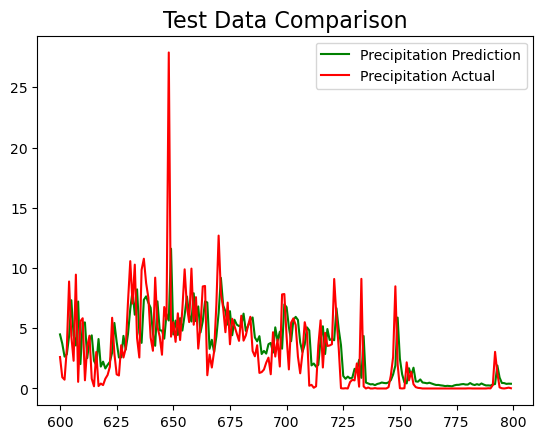

In [21]:
post_processed_df = plot_predictions_LSTM(model_LSTM,x_test,y_test)
plt.title('Test Data Comparison',fontsize = 16)
post_processed_df

## Train Data

344/344 [==============================] - 1s 2ms/step


,Precipitation Prediction,Precipitation Actual
600,4.601510,3.99
601,4.066041,2.38
602,3.772173,8.86
603,7.264534,3.63
604,4.424752,2.01
...,...,...
795,0.282789,0.00
796,0.259396,0.00
797,0.245237,0.00
798,0.225700,0.00


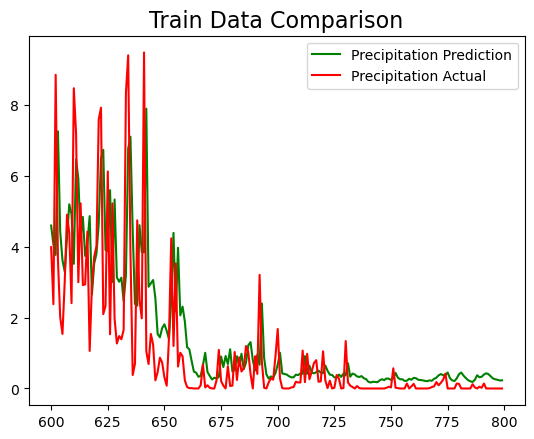

In [22]:
post_processed_df = plot_predictions_LSTM(model_LSTM,x_train,y_train)
plt.title('Train Data Comparison',fontsize = 16)
post_processed_df

## Validation Data

32/32 [==============================] - 0s 2ms/step


,Precipitation Prediction,Precipitation Actual
600,1.448912,0.59
601,1.604960,1.74
602,2.693373,0.38
603,1.606193,0.60
604,2.620034,0.32
...,...,...
795,2.388504,7.20
796,5.040496,6.81
797,5.429203,2.92
798,3.634914,1.35


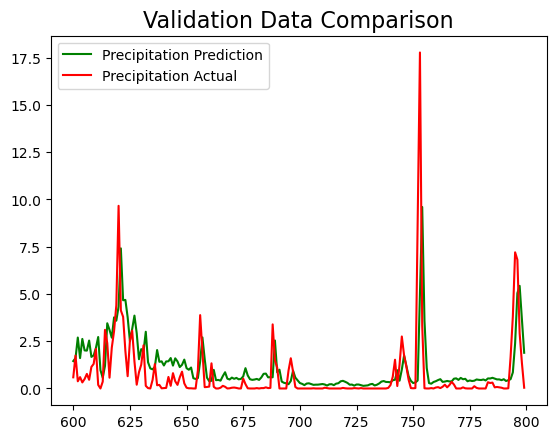

In [23]:
post_processed_df = plot_predictions_LSTM(model_LSTM,x_val,y_val)
plt.title('Validation Data Comparison',fontsize = 16)
post_processed_df

# Prediction

48/48 [==============================] - 0s 2ms/step


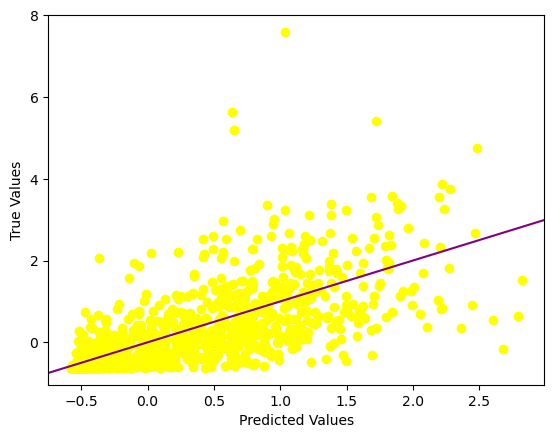

In [24]:
Y_predict = model_LSTM.predict(x_test)
plt.scatter(Y_predict, y_test, color = 'yellow')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_=plt.plot([-100,100],[-100,100], color = 'purple')

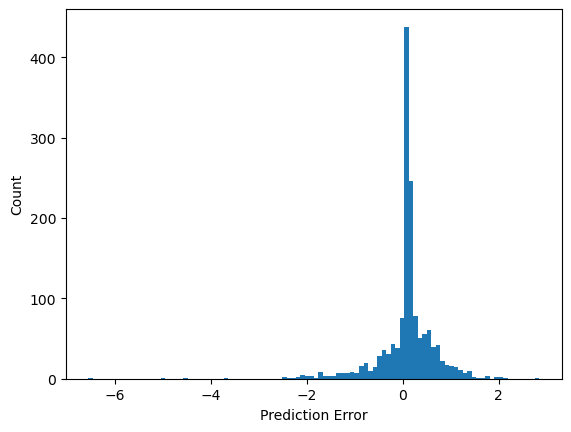

In [25]:
error = Y_predict.reshape(1513,) - y_test
plt.hist(error,bins = 100)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_=plt.ylabel("Count")

In [26]:
from sklearn.metrics import r2_score
r2_score(y_test,Y_predict)

0.5408136594366554

# Convolution 1D

In [27]:
model_conv1D = Sequential()
model_conv1D.add(InputLayer((3,7)))
model_conv1D.add(Conv1D(64, kernel_size = 2))
model_conv1D.add(Flatten())
model_conv1D.add(Dense(8,'relu'))
model_conv1D.add(Dense(1,'linear'))

model_conv1D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             960       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
cp2 = ModelCheckpoint('model_conv1D/',save_best_only = True)
model_conv1D.compile(loss = MeanSquaredError(), 
                   optimizer = Adam(learning_rate = 0.0001), 
                   metrics = [RootMeanSquaredError()]
              )

In [29]:
model_conv1D.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])

Epoch 1/10
344/344 [==============================] - 1s 2ms/step - loss: 1.3754 - root_mean_squared_error: 1.1728 - val_loss: 0.7444 - val_root_mean_squared_error: 0.8628
Epoch 2/10
344/344 [==============================] - 0s 1ms/step - loss: 0.7093 - root_mean_squared_error: 0.8422 - val_loss: 0.6017 - val_root_mean_squared_error: 0.7757
Epoch 3/10
344/344 [==============================] - 0s 1ms/step - loss: 0.6121 - root_mean_squared_error: 0.7824 - val_loss: 0.5611 - val_root_mean_squared_error: 0.7490
Epoch 4/10
344/344 [==============================] - 0s 1ms/step - loss: 0.5658 - root_mean_squared_error: 0.7522 - val_loss: 0.5126 - val_root_mean_squared_error: 0.7159
Epoch 5/10
344/344 [==============================] - 0s 1ms/step - loss: 0.5458 - root_mean_squared_error: 0.7388 - val_loss: 0.4992 - val_root_mean_squared_error: 0.7066
Epoch 6/10
344/344 [==============================] - 0s 1ms/step - loss: 0.5344 - root_mean_squared_error: 0.7311 - val_loss: 0.4986 - val_

In [30]:
def postprocess_precip(arr):
    arr = (arr * precip_train_std) + precip_train_mean
    return arr

In [31]:
def plot_predictions_conv1D (model2, x, y, start = 600, end = 800):
    prediction = model_conv1D.predict(x)
    precip_prediction = postprocess_precip(prediction[:,0])
    precip_actual = postprocess_precip(y[:,])
    df = pd.DataFrame(data = {'Precipitation Prediction': precip_prediction,
                              'Precipitation Actual': precip_actual,
                              })
    plt.plot(df['Precipitation Prediction'][start:end], color = 'green')
    plt.plot(df['Precipitation Actual'][start:end], color = 'red')
    plt.legend(['precip_prediction','precip_actual'],loc=0)
    return df[start:end]

48/48 [==============================] - 0s 912us/step


Text(0.5, 1.0, 'Test Data Comparison using Con1D')

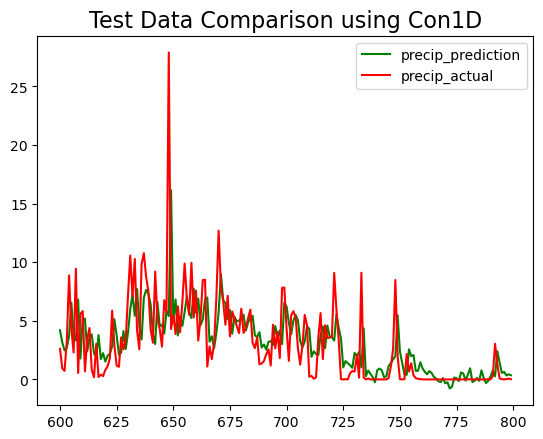

In [32]:
plot_predictions_conv1D(model_conv1D,x_test,y_test)
plt.title('Test Data Comparison using Con1D',fontsize = 16)

## prediction

48/48 [==============================] - 0s 945us/step


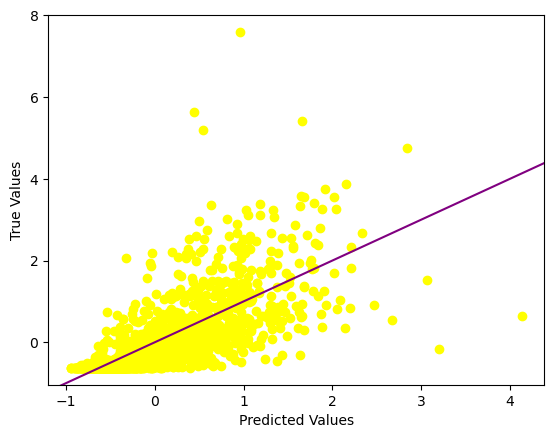

In [33]:
Y_predict = model_conv1D.predict(x_test)
plt.scatter(Y_predict, y_test, color = 'yellow')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_=plt.plot([-100,100],[-100,100], color = 'purple')

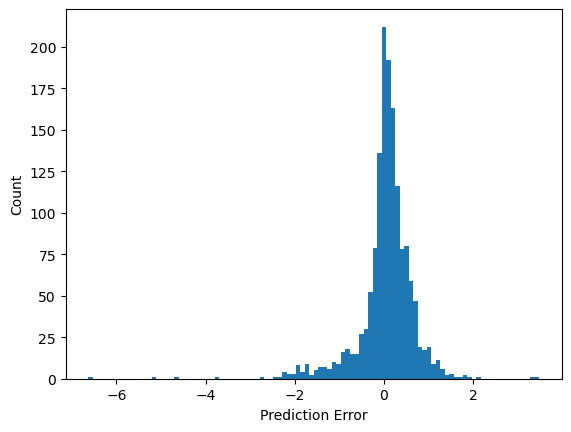

In [34]:
error = Y_predict.reshape(1513,) - y_test
plt.hist(error,bins = 100)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_=plt.ylabel("Count")

In [35]:
from sklearn.metrics import r2_score
r2_score(y_test,Y_predict)

0.5179948643399723